In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
import keras
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [4]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Validation',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumar Data set/Dataset/New folder (2)/Test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 2180 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Found 629 images belonging to 3 classes.


In [7]:
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

87910968/87910968 [==============================] - 1s 0us/step


In [8]:
InceptionV3.trainable = False

In [9]:
model = tf.keras.models.Sequential([
  InceptionV3,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='softmax'), 
])

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 74,758,947
Trainable params: 52,956,163
No

In [11]:
history = model.fit(
    x = train, 
    validation_data = validation,
    epochs = 10
)

Epoch 1/10
69/69 [==============================] - 556s 8s/step - loss: 3.6644 - accuracy: 0.6647 - val_loss: 1.7499 - val_accuracy: 0.4771
Epoch 2/10
69/69 [==============================] - 333s 5s/step - loss: 0.6340 - accuracy: 0.7794 - val_loss: 1.3590 - val_accuracy: 0.5163
Epoch 3/10
69/69 [==============================] - 341s 5s/step - loss: 0.4064 - accuracy: 0.8399 - val_loss: 1.2139 - val_accuracy: 0.5163
Epoch 4/10
69/69 [==============================] - 333s 5s/step - loss: 0.4043 - accuracy: 0.8440 - val_loss: 0.9393 - val_accuracy: 0.5915
Epoch 5/10
69/69 [==============================] - 342s 5s/step - loss: 0.3862 - accuracy: 0.8528 - val_loss: 1.4398 - val_accuracy: 0.4837
Epoch 6/10
69/69 [==============================] - 356s 5s/step - loss: 0.3244 - accuracy: 0.8798 - val_loss: 1.1977 - val_accuracy: 0.5131
Epoch 7/10
69/69 [==============================] - 358s 5s/step - loss: 0.3242 - accuracy: 0.8665 - val_loss: 1.2535 - val_accuracy: 0.5556
Epoch 8/10
69

In [12]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

20/20 [==============================] - 154s 8s/step - loss: 0.7967 - accuracy: 0.7154
Accuracy: 0.7154213190078735
Loss: 0.7966718673706055


In [13]:
test.class_indices

{'glioma': 0, 'meningioma': 1, 'pituitary_tumor': 2}

In [14]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['glioma', 'glioma', 'pituitary_tumor']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

20/20 [==============================] - 83s 4s/step
                 precision    recall  f1-score   support

         glioma       0.99      0.54      0.70       291
         glioma       0.48      0.71      0.57       152
pituitary_tumor       0.76      0.99      0.86       186

       accuracy                           0.72       629
      macro avg       0.74      0.75      0.71       629
   weighted avg       0.80      0.72      0.72       629



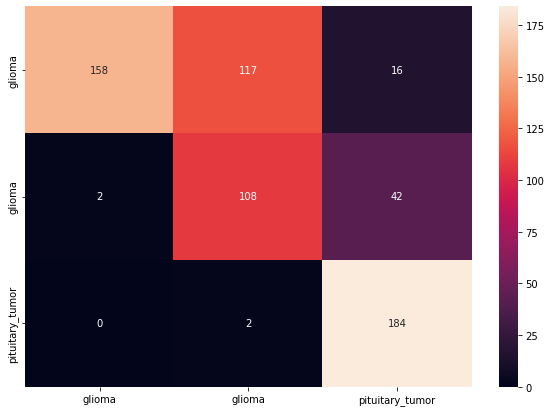

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['glioma', 'glioma', 'pituitary_tumor']],
                  columns = [i for i in ['glioma', 'glioma', 'pituitary_tumor']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

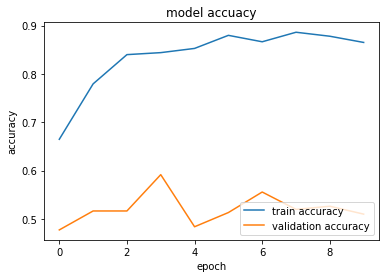

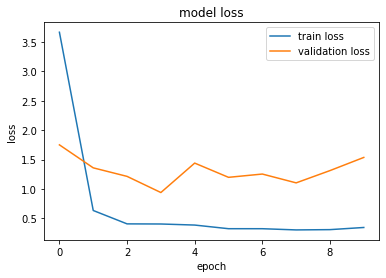

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()